# Imports and visualization settings

In [12]:
import numpy as np
import seaborn as sns

from queue import PriorityQueue

In [2]:
np.random.seed(44)

In [3]:
import matplotlib.pyplot as plt
import matplotlib.dates as md
%matplotlib inline
plt.style.use('ggplot')
import matplotlib as mpl
mpl.rcParams['xtick.labelsize'] = 12
mpl.rcParams['ytick.labelsize'] = 12
mpl.rcParams['axes.labelsize'] = 16
mpl.rcParams['figure.figsize'] = (14, 8)
mpl.rcParams["patch.force_edgecolor"] = True

# The rules of the simulation are simple:

1. Each week, a new task is added to a priority queue. Each new task has a Value selected at random from 1 to 5 and an Effort selected at random from a Fibonacci subset {2, 3, 5, 8, 13, 21, 34, 55, 89}. 

2. Upon completing a task, the Contributor earns points equal to the product of the Value and Effort of the task.

3. Upon completing a task, the Contributor selects the highest priority Task. Tasks with highest Value are prioritized. To settle ties in Value, tasks with lowest Effort are prioritized.

4. Switching from one task to another incurs a Cost (see switch_cost argument in simulation).  

5. A Contributor can pay off one unit of that Cost each day. 

6. Provided the Contributor has paid off all Cost, a Contributor can complete one unit of Effort each day.

7. To simulate the action of other Contributors, the highest priority task in the priority queue is removed at an expected rate of once per 10 days.


In [4]:
# Rule 1
EFFORT_LEVELS = [2, 3, 5, 8, 13, 21, 34, 55, 89] # effort levels reflecting common LoE estimation convention
VALUE_LEVELS = 5 # 5 value levels

class Task:
    """
    Abstraction of a Task, with random initialization, prioritization, and decrement definitions
    """
    
    def __init__(self):
    
        self.value = 1 + np.random.choice(VALUE_LEVELS)
        self.effort_remaining = np.random.choice(EFFORT_LEVELS)
        self.effort_initial = self.effort_remaining
        
    def __gt__(self, other):
        """
        Ensures that highest value, lowest effort tasks are prioritized in queue.
        """
        
        if self.value < other.value:
            return True
        elif self.value == other.value:
            return self.effort_initial >= other.effort_initial
        else:
            return False
        
    def __str__(self):
        return str([self.value, self.effort_remaining, self.effort_initial])
        
    def progress(self):
        
        self.effort_remaining -= 1
          

In [5]:

def simulate_priority(switch_cost, always_switch, 
                      days_of_simulation=365, task_addition_time=7, task_removal_time=10.0):
    """
    Simulate the total value of an individual contributor.
    
    Inputs:
    switch_cost (int) - the cost incurred (in days) to switch from one task to another
    always_switch (bool) - whether to always switch (versus always finish) 
        a task if there is a higher value task available
    days_of_simulation (int) - total days of simulation
    task_addition_time (int) - days to addition of new task
    task_removal_time (int) - average days to removal of task (by another Contributor)
    
    Outputs:
    (float) - average value per day
    (list[int]) - value of current task each day of simulation
    """

    # initialize metrics
    cum_points = 0 # initialize value*effort points
    value_vs_days = [] # keep track of value by day
    
    # initialize simulation
    tasks = PriorityQueue()
    current_task = Task() # first task
    switching_cost = 0 # assume no initial switching cost
    
    for day_i in range(days_of_simulation):
        
        # save values for diagnostics
        value_vs_days.append(current_task.value)
            
        # Rule 7
        if (np.random.random() < (1.0 / task_removal_time)) & (not tasks.empty()):
            tasks.get()
            
        # task complete
        if current_task.effort_remaining == 0: 
            
            # Rule 2
            cum_points += current_task.value * current_task.effort_initial
            
            # Rule 3
            if not tasks.empty(): # get highest priority
                current_task = tasks.get()
            else: # get new task at random
                current_task = Task()
    
        # Rule 1
        if day_i % task_addition_time == 0:
            new_task = Task()

            # Always Switch decision policy
            if always_switch & (new_task.value > current_task.value): 
                tasks.put(current_task) 
                current_task = new_task
                
                # Rule 4
                switching_cost = switch_cost
                
            # Always Finish decision policy
            else: # put new task into queue
                tasks.put(new_task)

        # Rule 6
        if switching_cost == 0: 
            current_task.progress()
            
        # Rule 5
        else:
            switching_cost -= 1

    return cum_points / days_of_simulation, value_vs_days

## Run parametric simulation to understand value of current task as a function of days

In [ ]:
n = 365 # days for each simulation
m = 3000 # monte carlo trials

avg_y_vs_days = np.zeros(n)
for i in range(1000):
    _, y_vs_days = simulate_priority(7, True, days_of_simulation=n)
    avg_y_vs_days = 1 / (i + 1) * np.array(y_vs_days) + i / (i + 1) * avg_y_vs_days
    
plt.plot(avg_y_vs_days)

avg_y_vs_days = np.zeros(n)
for i in range(1000):
    _, y_vs_days = simulate_priority(7, False, days_of_simulation=n)
    avg_y_vs_days = 1 / (i + 1) * np.array(y_vs_days) + i / (i + 1) * avg_y_vs_days
    
plt.plot(avg_y_vs_days);

# The value of the current task is considerably higher with the Always Switch policy.

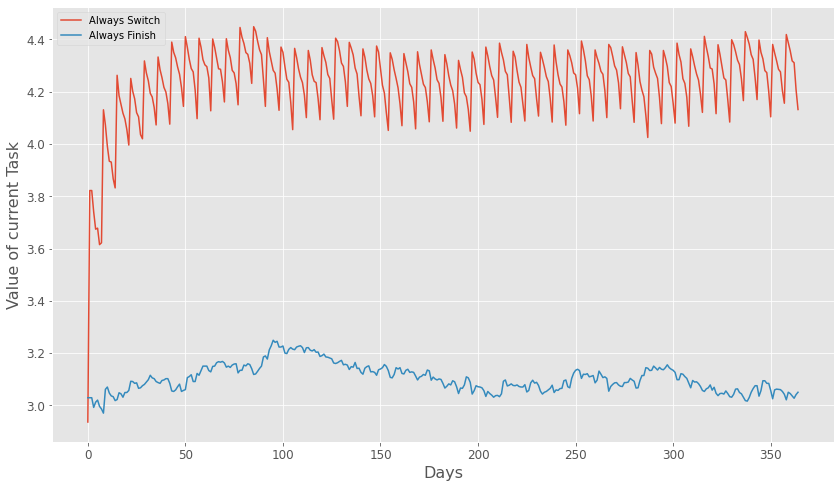

In [6]:
plt.xlabel('Days')
plt.ylabel('Value of current Task')
plt.legend(['Always Switch', 'Always Finish']);

## Run parametric simulation to understand average value per day as a function of Cost

In [7]:
m = 3000
n = 365

avg_rzn_switching = []
avg_rzn_no_switching = []
for cost in range(7):
    
    rzns_switching = []
    for _ in range(m):
        rzn, _ = simulate_priority(cost, True, days_of_simulation=n)
        rzns_switching.append(rzn)

    rzns_no_switching = []
    for _ in range(m):
        rzn, _ = simulate_priority(cost, False, days_of_simulation=n)
        rzns_no_switching.append(rzn)
        
    avg_rzn_switching.append(np.mean(rzns_switching))
    avg_rzn_no_switching.append(np.mean(rzns_no_switching))


# However, assuming a seven-day context switching cost, the average value created per day is generally higher for the Always Finish policy, because you get to completion on more work

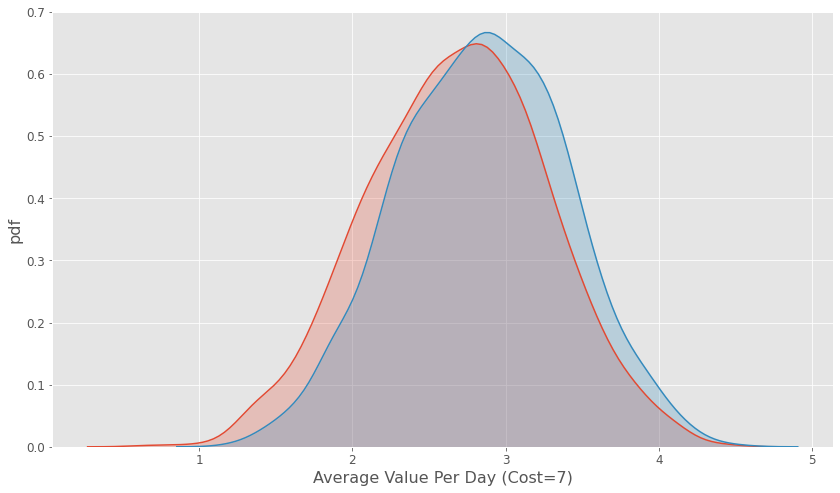

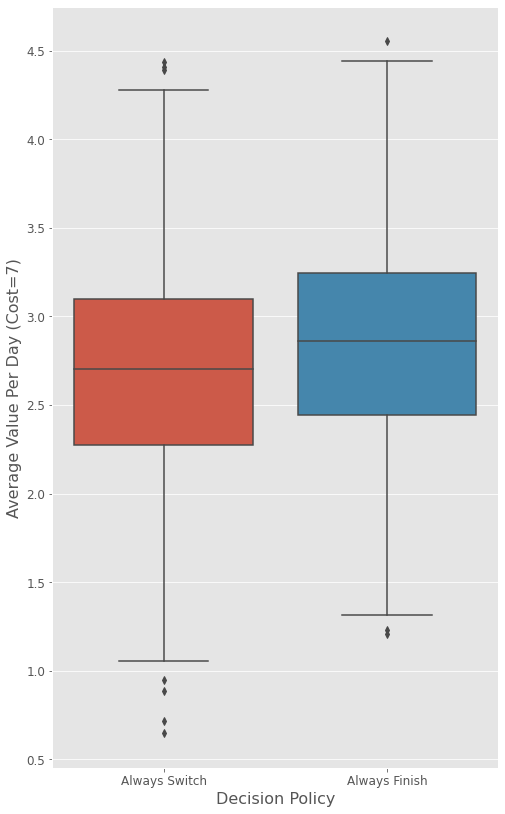

In [11]:
sns.kdeplot(rzns_switching, shade=True)
sns.kdeplot(rzns_no_switching, shade=True);
plt.xlabel('Average Value Per Day (Cost=7)')
plt.ylabel('pdf');
plt.show();

plt.figure(figsize=(8, 14))
sns.boxplot(data=(rzns_switching, rzns_no_switching));
ax = plt.gca()
ax.set_xticklabels(['Always Switch', 'Always Finish'])
plt.xlabel('Decision Policy')
plt.ylabel('Average Value Per Day (Cost=7)')
plt.show();

# This simulation estimates the point of crossover at three days.  Many ICs would argue that contextual switching costs are greater than this in many contexts.

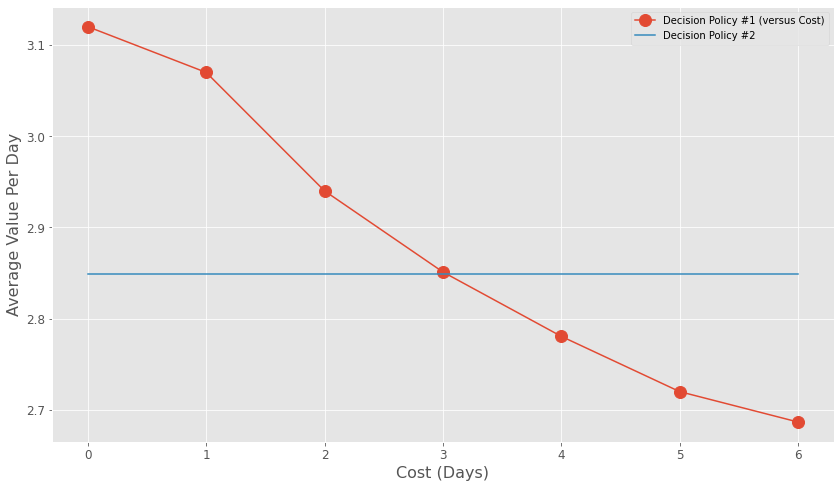

In [10]:
plt.plot(avg_rzn_switching, marker='o', markersize=12)
plt.plot(np.mean(avg_rzn_no_switching) * np.ones(7))
plt.xlabel('Cost (Days)')
plt.ylabel('Average Value Per Day');
plt.legend(['Decision Policy #1 (versus Cost)', 'Decision Policy #2']);